# X-Ray data exploration for COVID-19

A formal writeup for project Vesta can be found on my [personal website](https://hectorcarrion.com/home/vesta).

The aim of this project is to train a model that will classify weather a given chest X-Ray presents COVID-19, Pneumonia or is Normal.

This notebook will cover:

-  Generating
-  Sampling
-  Overlap
-  Visualization
-  Preprocessing

### Packages

In [ ]:
import train_util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
sns.set()

### Generating the Dataset

I will be using my custom split of data compiled from these three repositories

-  https://github.com/ieee8023/covid-chestxray-dataset
-  https://github.com/agchung/Figure1-COVID-chestxray-dataset
-  https://nihcc.app.box.com/v/ChestXray-NIHCC

Number of images collected as of April 18th, 2020

-  Normal:  8,851
-  Pneumonia: 6,045
-  COVID-19: 251

Given the shortage of COVID images, several techniques were used to balance the dataset:

-  Undersampling of the dominant classes
-  Oversampling of COVID on validation and test sets
-  Weighted loss function

### Sampling strategy

In studies, test sets are often sampled to contain at least X% of the minority class. In this case, I sampled the test set such that its composed of 20% of COVID cases, 40% Pneumonia and 40% Normal.

The validation set ideally reflects the distribution of the test set, so I applied the same sampling distribution.

Finally, the remaining patients can be included in the train set. However the dominant cases have been undersampled to 1,000 images each.

The resulting splits are:

-  Test set
   - Normal: 60
   - Pneumonia: 60
   - COVID: 30

-  Validation set
   -  Normal: 60
   -  Pneumonia: 60
   -  COVID-19: 30

-  Train set
   -  Normal: 1,000
   -  Pneumonia: 1,000
   -  COVID-19: 191

*Note: this random re-sampling has accounted for patient overlap and we will corroborate this in code.*

These splits have been saved as `test_small.txt`, `val_small.txt` and `train_small.txt`. Let's load them and take a peek



In [ ]:
train_df = pd.read_csv("train_small.txt", delimiter = " ")
val_df = pd.read_csv("val_small.txt", delimiter = " ")
test_df = pd.read_csv("test_small.txt", delimiter = " ")

In [ ]:
val_df

,PatientID,Image,Normal,Pneumonia,Covid19,View
0,20,covid-19-pneumonia-15-PA.jpg,0,0,1,PA
1,43,CD50BA96-6982-4C80-AE7B-5F67ACDBFA56.jpeg,0,0,1,PA
2,44,85E52EB3-56E9-4D67-82DA-DEA247C82886.jpeg,0,0,1,PA
3,45,6CB4EFC6-68FA-4CD5-940C-BEFA8DAFE9A7.jpeg,0,0,1,PA
4,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,0,0,1,PA
...,...,...,...,...,...,...
145,3485bc68-5c84-479c-8ec6-17fa1b6d7a2c,3485bc68-5c84-479c-8ec6-17fa1b6d7a2c.png,0,1,0,NaN
146,3489804c-d115-4f87-b5c9-301462cdcad4,3489804c-d115-4f87-b5c9-301462cdcad4.png,0,1,0,NaN
147,34956207-2ebf-4a47-bc56-faf23701adf2,34956207-2ebf-4a47-bc56-faf23701adf2.png,0,1,0,NaN
148,349f10b4-dc3e-4f3f-b2e4-a5b81448ce87,349f10b4-dc3e-4f3f-b2e4-a5b81448ce87.png,0,1,0,NaN


As you can see, each row has:
-  Patient's ID number (or string)
-  Image file name
-  Ground truth labeling
-  View parameter (which is not always avaliable).

PA or AP refers to the direction that the X-rays are entering your body.

In a PA view, the patient would be standing facing the image receptor. The X-Rays would pass through the POSTERIOR (back) side of the body first and exist the ANTERIOR (front). Thus the term PA. The AP view is the opposite.

For us, because most images arent actually labeled with their views we will not be taking it into account.

## Unique patients

One thing you'd like to know about a medical dataset like this is if you're looking at repeated data for certain patients or whether each image represents a different person.

In [ ]:
print(f"The total patient ids on our train set is {train_df['PatientID'].count()}, from those the unique ids are {train_df['PatientID'].value_counts().shape[0]}.")
print(f"The total patient ids on our val set is {val_df['PatientID'].count()}, from those the unique ids are {val_df['PatientID'].value_counts().shape[0]}.")
print(f"The total patient ids on our test set is {test_df['PatientID'].count()}, from those the unique ids are {test_df['PatientID'].value_counts().shape[0]}.")

The total patient ids on our train set is 2191, from those the unique ids are 2118.
The total patient ids on our val set is 150, from those the unique ids are 145.
The total patient ids on our test set is 150, from those the unique ids are 130.


### Check for overlap

Allowing the same patinent to appear on different sets could allow the model to overfit to a particular aspect of that patient. A marking, a necklace or something that could let our model 'cheat' on its prediction.

Let's check for overlap:

In [ ]:
print(util.check_for_leakage(train_df, val_df, 'PatientID'))
print(util.check_for_leakage(train_df, test_df, 'PatientID'))
print(util.check_for_leakage(test_df, val_df, 'PatientID'))

False
False
False


We should see three **False** statements, representing no patient overlap between our sets.

## Data Visualization

Let's visualize some random images from our test set.

Display Random Images


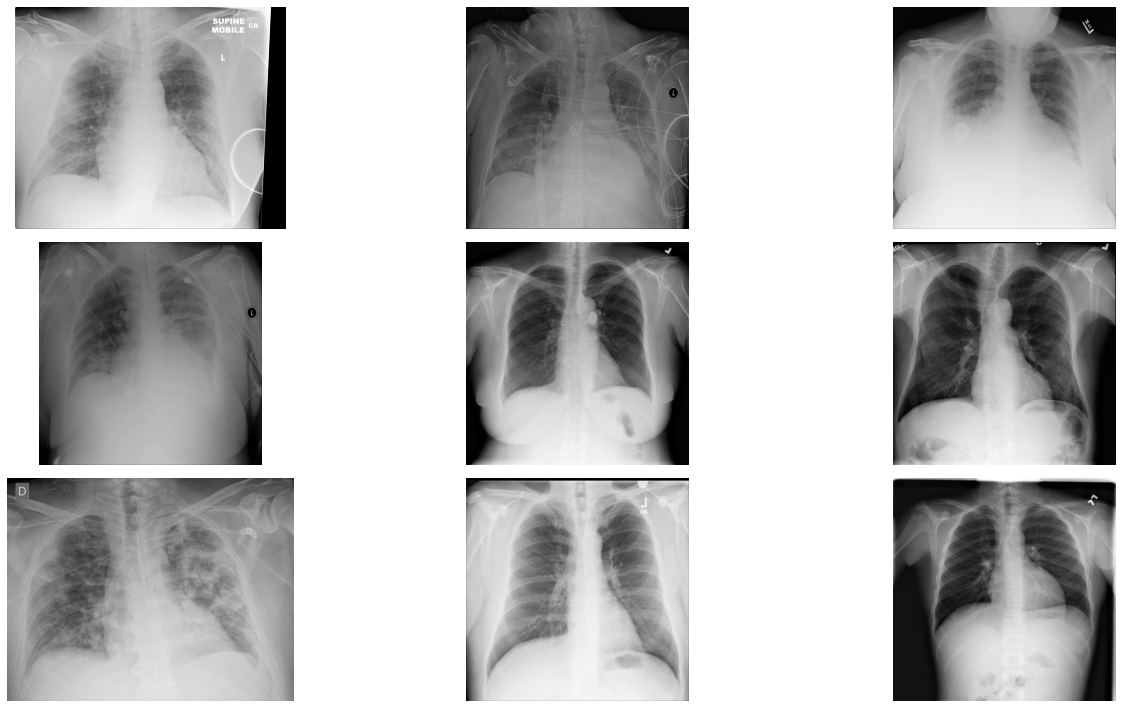

In [ ]:
# Extract numpy values from Image column in data frame
images = test_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'data/'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

### Image details

The dimensions of the image are 1593 pixels width and 1800 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 67.0000
The mean value of the pixels is 189.2936 and the standard deviation is 49.4764


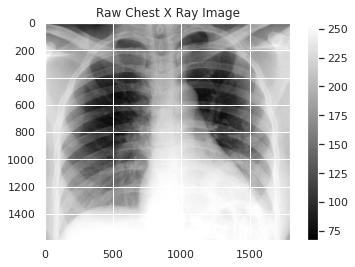

In [ ]:
# Get the first image that was listed in the train_df dataframe
sample_img = test_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

As you can see, we have very large images that will need to be resized. Pixel values that will have to be normalized and a single color chanel to consider as these are gray scale images.

### Pixel value distribution for the above picture

Text(0, 0.5, '# Pixels in Image')

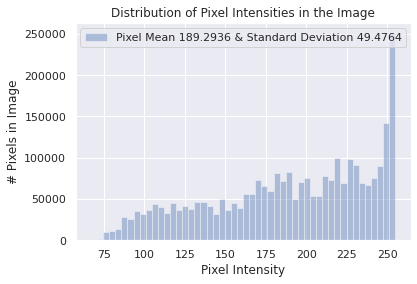

In [ ]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

## Preprocessing images

We will use Keras to normalize our images before training

In [ ]:
# Normalize images
image_generator = ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True # Divide each input by its standard deviation
)

The generator above will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

In [ ]:
# Flow from directory with specified batch size and target image size
generator = image_generator.flow_from_dataframe(
        dataframe = test_df,
        directory = img_dir,
        x_col = "Image", # features
        y_col = ['Covid19'], # labels
        class_mode = "raw", # 'Mass' column should be in train_df
        batch_size = 1, # images per batch
        shuffle = False, # shuffle the rows or not
        target_size = (320,320) # width and height of output image
)

Found 150 validated image filenames.


In [ ]:
# Plot a processed image
sns.set_style("white")
generated_image, label = generator.__getitem__(0)

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 1.3281 and the minimum is -2.4315
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


We now have much smaller images with normalized pixel values. Time to do some [training!](https://)